# Player Pose Estimation (Image)

In [1]:
import os

import mmcv
import mmengine

from mmpose.apis import inference_topdown
from mmpose.apis import init_model as init_pose_estimator
from mmpose.evaluation.functional import nms
from mmpose.structures import merge_data_samples
from mmpose.utils import adapt_mmdet_pipeline

try:
    from mmdet.apis import inference_detector, init_detector
    has_mmdet = True
except (ImportError, ModuleNotFoundError):
    has_mmdet = False

import matplotlib.pyplot as plt
import numpy as np
import cv2

## Configs

In [2]:
device = "cuda:0"

det_config = "../../configs/mmdet/faster_rcnn_r50_fpn_coco.py"
det_checkpoint = "https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth"

pose_config = "../../configs/mmpose/td-hm_hrnet-w48_8xb32-210e_coco-384x288.py"
pose_checkpoint = "https://download.openmmlab.com/mmpose/v1/body_2d_keypoint/topdown_heatmap/coco/td-hm_hrnet-w48_8xb32-210e_coco-384x288-c161b7de_20220915.pth"

input_img = "input.jpg"

## Initialize detectors

In [3]:
# Build detector
detector = init_detector(det_config, det_checkpoint, device)
detector.cfg = adapt_mmdet_pipeline(detector.cfg)

# Build pose estimator
pose_estimator = init_pose_estimator(pose_config, pose_checkpoint, device)

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/v1/body_2d_keypoint/topdown_heatmap/coco/td-hm_hrnet-w48_8xb32-210e_coco-384x288-c161b7de_20220915.pth
The model and loaded state dict do not match exactly

unexpected key in source state_dict: data_preprocessor.mean, data_preprocessor.std



## Initialize visualizer

In [4]:
# init visualizer
from mmpose.registry import VISUALIZERS

pose_estimator.cfg.visualizer.radius = 3
pose_estimator.cfg.visualizer.alpha = 1
pose_estimator.cfg.visualizer.line_width = 1
visualizer = VISUALIZERS.build(pose_estimator.cfg.visualizer)

# the dataset_meta is loaded from the checkpoint and
# then pass to the model in init_pose_estimator
visualizer.set_dataset_meta(
    pose_estimator.dataset_meta, skeleton_style="mmpose")

04/23 01:51:16 - mmengine - WARNING - `Visualizer` backend is not initialized because save_dir is None.


## Pose estimation

In [5]:
# predict bbox
det_result = inference_detector(detector, input_img)
pred_instance = det_result.pred_instances.cpu().numpy()
bboxes = np.concatenate(
    (pred_instance.bboxes, pred_instance.scores[:, None]), axis=1)
bboxes = bboxes[np.logical_and(pred_instance.labels == 0,
                               pred_instance.scores > 0.3)]
bboxes = bboxes[nms(bboxes, 0.3), :4]

# predict keypoints
pose_results = inference_topdown(pose_estimator, input_img, bboxes)
data_samples = merge_data_samples(pose_results)

# show the results
if isinstance(input_img, str):
    input_img = mmcv.imread(input_img, channel_order='rgb')
elif isinstance(input_img, np.ndarray):
    input_img = mmcv.bgr2rgb(input_img)

visualizer.add_datasample(
    'result',
    input_img,
    data_sample=data_samples,
    draw_gt=False,
    draw_heatmap=False,
    draw_bbox=False,
    show_kpt_idx=True,
    skeleton_style="mmpose",
    show=False,
    wait_time=0,
    kpt_thr=0.3)

len(data_samples.pred_instances.keypoints)

13

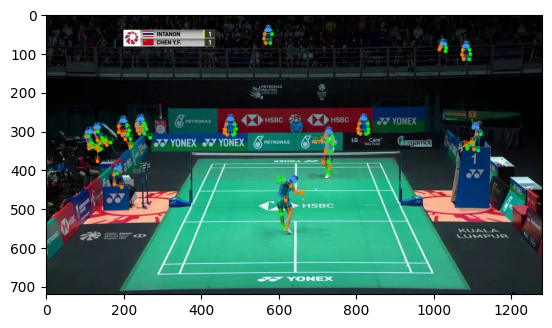

In [6]:
pose_img = visualizer.get_image()

plt.imshow(pose_img)

## Filter poses

(427, 382) (858, 382) (997, 666) (288, 666)


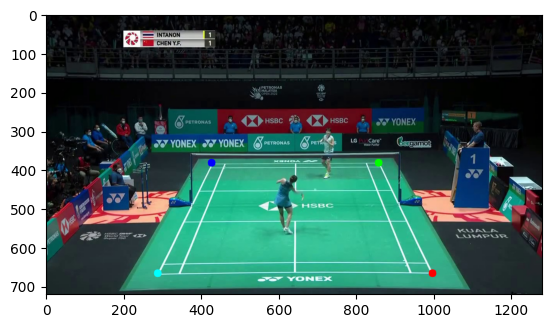

In [7]:
import csv

# Load court corners
with open("court.csv") as csv_file:
    csv_reader = csv.DictReader(csv_file)
    court_corners = next(csv_reader)

ul = (int(court_corners["upper_left_x"]), int(court_corners["upper_left_y"]))
ur = (int(court_corners["upper_right_x"]), int(court_corners["upper_right_y"]))
lr = (int(court_corners["lower_right_x"]), int(court_corners["lower_right_y"]))
ll = (int(court_corners["lower_left_x"]), int(court_corners["lower_left_y"]))
court_pts = np.array([ul, ur, lr, ll])

print(ul, ur, lr, ll)

# Visualize court corners
tmp = input_img.copy()
cv2.circle(tmp, (ul[0], ul[1]), 10, (0, 0, 255), -1)
cv2.circle(tmp, (ur[0], ur[1]), 10, (0, 255, 0), -1)
cv2.circle(tmp, (lr[0], lr[1]), 10, (255, 0, 0), -1)
cv2.circle(tmp, (ll[0], ll[1]), 10, (0, 255, 255), -1)

plt.imshow(tmp)

In [8]:
player_poses = []

# Filter out all the poses that does not has its feet inside the court
for pose in pose_results:
    keypoints = pose.pred_instances.keypoints[0]
    if len(keypoints) < 17:
        continue

    left_foot_coord = (int(keypoints[16][0]), int(keypoints[16][1]))
    right_foot_coord = (int(keypoints[15][0]), int(keypoints[15][1]))
    
    if cv2.pointPolygonTest(court_pts, left_foot_coord, False) != -1 or cv2.pointPolygonTest(court_pts, right_foot_coord, False) != -1:
        player_poses.append(pose)

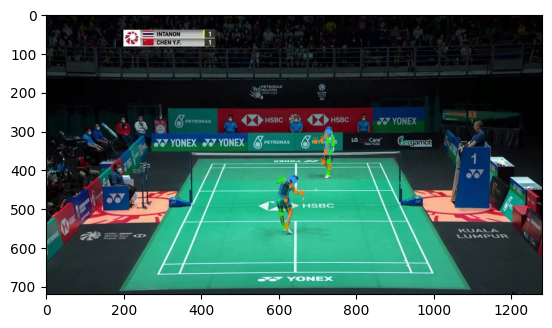

In [9]:
# Visualize player poses
player_data_samples = merge_data_samples(player_poses)
visualizer.add_datasample(
    'result',
    input_img,
    data_sample=player_data_samples,
    draw_gt=False,
    draw_heatmap=False,
    draw_bbox=False,
    show_kpt_idx=True,
    skeleton_style="mmpose",
    show=False,
    wait_time=0,
    kpt_thr=0.3)

player_pose_img = visualizer.get_image()
plt.imshow(player_pose_img)